In [1]:
from plot import score_metrics_and_granularity
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()

# Tier 3 Geoloc error

2024-05-02 14:26:06.008 | INFO     | plot:score_metrics_and_granularity:601 - eval_file=PosixPath('/storage/hugo/geogiant/geogiant/common/../results/tier3_evaluation/results__best_hostname_geo_score.pickle') loaded
2024-05-02 14:26:06.022 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection, median_error=6.22 [km], None hostnames
2024-05-02 14:26:06.024 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard, median_error=6.14 [km], None hostnames
2024-05-02 14:26:06.027 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection_scope_poly_weight, median_error=6.13 [km], None hostnames
2024-05-02 14:26:06.029 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard_scope_linear_weight, median_error=5.87 [km], None hostnames
2024-05-02 14:26:06.042 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection, median_error=6.22 [km], None hostnames
2024-05-02 14:26:06.044 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard, med

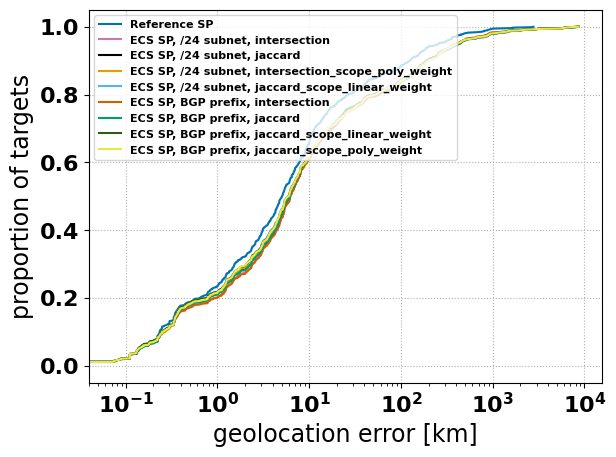

In [2]:
score_metrics_and_granularity(
    eval_dir=path_settings.RESULTS_PATH / "tier3_evaluation",
    output_path="score_metrics_and_granularity",
    metric_evaluated="d_error",
    plot_zp=False,
)

# Tier3 VP selection

2024-05-02 14:26:15.676 | INFO     | plot:score_metrics_and_granularity:601 - eval_file=PosixPath('/storage/hugo/geogiant/geogiant/common/../results/tier3_evaluation/results__best_hostname_geo_score.pickle') loaded
2024-05-02 14:26:15.690 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection, median_error=0.86 [km], None hostnames
2024-05-02 14:26:15.692 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard, median_error=0.86 [km], None hostnames
2024-05-02 14:26:15.694 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection_scope_poly_weight, median_error=0.85 [km], None hostnames
2024-05-02 14:26:15.696 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard_scope_linear_weight, median_error=0.84 [km], None hostnames
2024-05-02 14:26:15.711 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: intersection, median_error=0.87 [km], None hostnames
2024-05-02 14:26:15.713 | INFO     | plot:plot_ecs_shortest_ping:293 - ECS SP:: jaccard, med

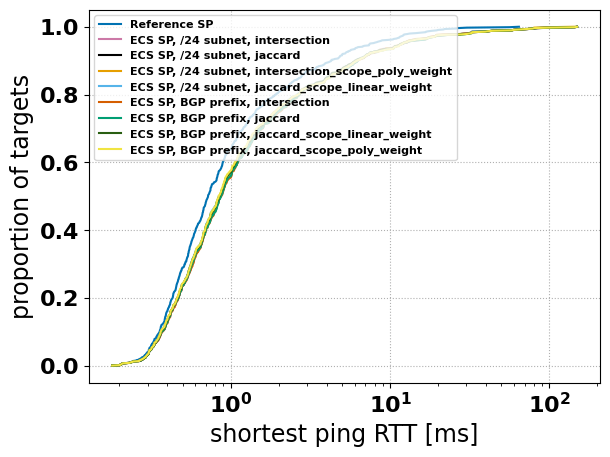

In [3]:
score_metrics_and_granularity(
    eval_dir=path_settings.RESULTS_PATH / "tier3_evaluation",
    output_path="score_metrics_and_granularity",
    metric_evaluated="rtt",
    plot_zp=False,
)